<a href="https://colab.research.google.com/github/lolddong/data_analysis/blob/main/23_IMDB_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB GRU
## 1. 패키지 준비하기

In [2]:
import helper
from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 2. 데이터셋 준비

In [4]:
# 가장 빈번하게 사용되는 단어의 개수
num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
print(f'훈련 데이터 {x_train.shape} 레이블 {y_train.shape}')
print(f'검증 데이터 {x_test.shape} 레이블 {y_test.shape}')

17464789/17464789 [==============================] - 0s 0us/step
훈련 데이터 (25000,) 레이블 (25000,)
검증 데이터 (25000,) 레이블 (25000,)


## 3. 데이터 전처리
### 1) 데이터를 동일한 길이로 맞추기 (padding)

In [9]:
# 최대 문장 길이
max_len = 500

print('Before pad_sequences: ', len(x_train[0]), len(x_train[1]))

pad_x_train = pad_sequences(x_train, maxlen=max_len, padding = 'pre')
pad_x_test = pad_sequences(x_test, maxlen=max_len, padding = 'pre')

# 원래 단어의 앞에 '지정해준 단어의 길이 - 원래 단어의 길이'(500-218)만큼 0이 추가된 것을 볼 수 있다.
print('After pad_sequences: ', len(pad_x_train[0]), len(pad_x_train[1]))

print(pad_x_train[0])

Before pad_sequences:  218 189
After pad_sequences:  500 500
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 

## 4. 데이터셋 분할하기
- 이미 데이터셋이 훈련데이터와 검증데이터로 분리되어 있기에 별도의 분할작업을 수행할 필요 없다
- 한다면 train_test_split 함수 사용

## 5. 모델 개발
- 모델 정의

In [10]:
my_model = Sequential()

my_model.add(Embedding(input_dim = num_words,
                       output_dim = 32,
                       input_length = max_len))
# 딱 한 틍만 쌓아야 한다 (개꿀!!)
my_model.add(GRU(32))
my_model.add(Dense(1, activation = 'sigmoid'))

# 결국은 긍정, 부정을 분류하는 문제이므로 이진 분류에 해당한다
my_model.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics = ['acc'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 326369 (1.24 MB)
Trainable params: 326369 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 학습하기

In [11]:
result = my_model.fit(pad_x_train, y_train,
                      epochs = 500,
                      validation_data = (pad_x_test,
                                         y_test),
                      callbacks=[EarlyStopping(monitor='val_loss',
                                               patience=5,
                                               verbose=1),
                                 ReduceLROnPlateau(monitor='val_loss',
                                                   patience=3,
                                                   factor=0.5,
                                                   min_lr=0.0001,
                                                   verbose=1)])

Epoch 1/500
782/782 [==============================] - 116s 138ms/step - loss: 0.4215 - acc: 0.7976 - val_loss: 0.3186 - val_acc: 0.8655 - lr: 0.0010
Epoch 2/500
782/782 [==============================] - 49s 63ms/step - loss: 0.2526 - acc: 0.9006 - val_loss: 0.2992 - val_acc: 0.8784 - lr: 0.0010
Epoch 3/500
782/782 [==============================] - 33s 43ms/step - loss: 0.1855 - acc: 0.9325 - val_loss: 0.3136 - val_acc: 0.8796 - lr: 0.0010
Epoch 4/500
782/782 [==============================] - 36s 46ms/step - loss: 0.1429 - acc: 0.9490 - val_loss: 0.3279 - val_acc: 0.8713 - lr: 0.0010
Epoch 5/500
782/782 [==============================] - ETA: 0s - loss: 0.1074 - acc: 0.9632
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 [==============================] - 24s 31ms/step - loss: 0.1074 - acc: 0.9632 - val_loss: 0.4166 - val_acc: 0.8608 - lr: 0.0010
Epoch 6/500
782/782 [==============================] - 24s 30ms/step - loss: 0.0592 - acc: 0.9831 - va

## 6. 학습 결과 평가

In [13]:
# helper.tf_result_plot(result)

evaluate1 = my_model.evaluate(pad_x_train, y_train)
print('최종 훈련 손실률: %f, 최종 훈련 정확도: %f'% (evaluate1[0], evaluate1[1]))
evaluate2 = my_model.evaluate(pad_x_test, y_test)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f'% (evaluate2[0], evaluate2[1]))

782/782 [==============================] - 7s 9ms/step - loss: 0.0259 - acc: 0.9946
최종 훈련 손실률: 0.025882, 최종 훈련 정확도: 0.994640
782/782 [==============================] - 7s 9ms/step - loss: 0.5058 - acc: 0.8690
최종 검증 손실률: 0.505804, 최종 검증 정확도: 0.868960


In [14]:
# 학습 결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace = True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.421502,0.79756,0.318646,0.86548,0.0010
2,0.252593,0.90064,0.299182,0.87844,0.0010
3,0.185495,0.93248,0.313639,0.87964,0.0010
4,0.142873,0.94904,0.327923,0.87128,0.0010
5,0.107435,0.96316,0.416633,0.86080,0.0010
6,0.059234,0.98308,0.444116,0.86668,0.0005
7,0.039151,0.98964,0.505804,0.86896,0.0005


In [15]:
# Colab 그래프 한글글꼴 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm-/.cache/matplotlib -rf

from matplotlib import font_manager as fm
import matplotlib.pyplot as plt
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                  name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120875 files and direc

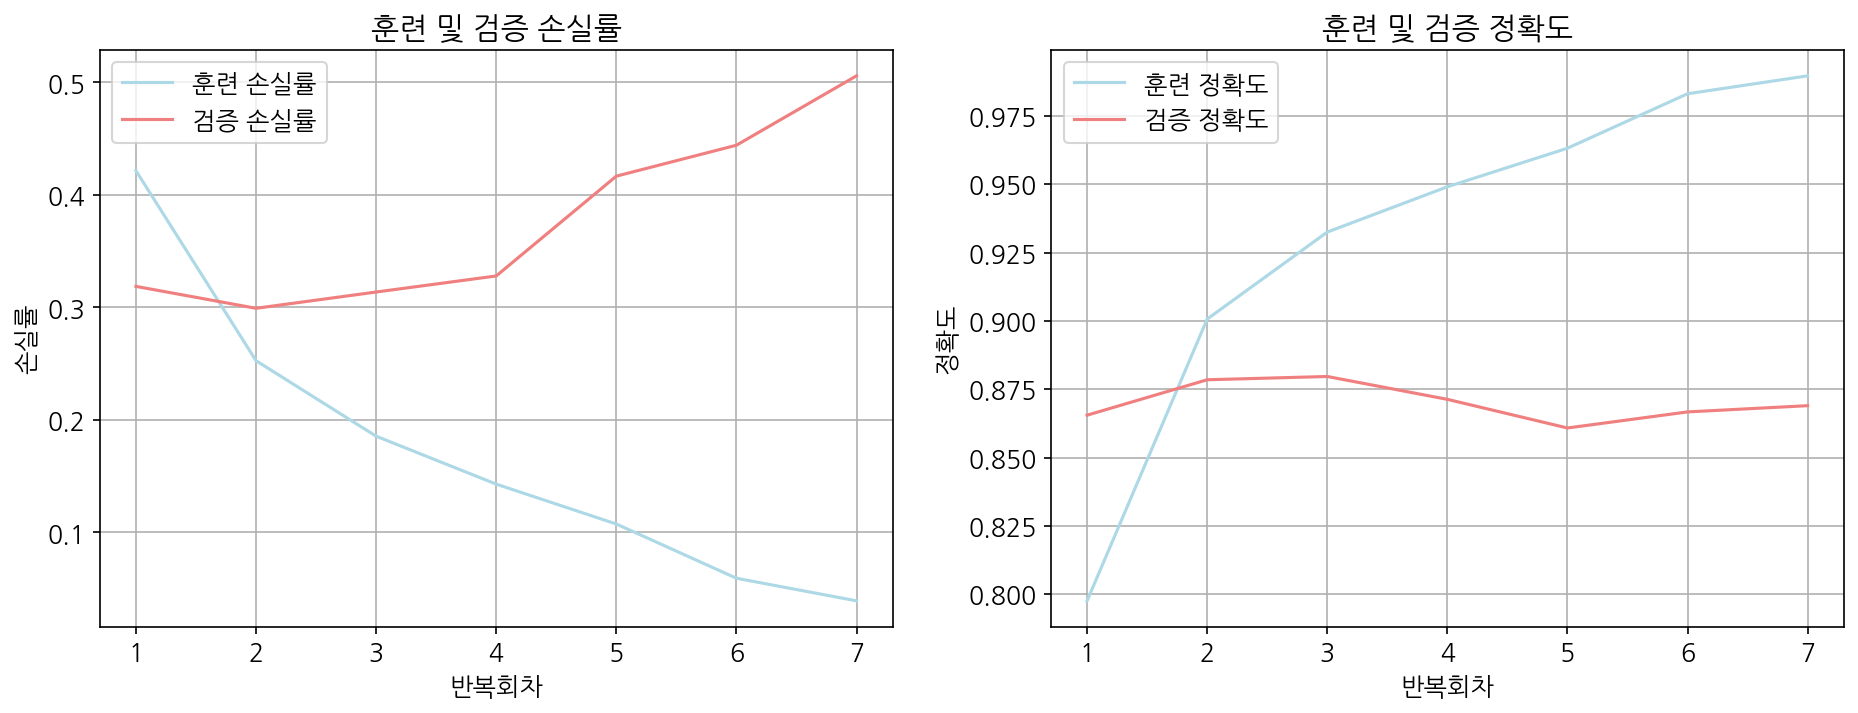

In [16]:
# 그래프 기본설정
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
sb.lineplot(x=result_df.index,
            y='loss',
            data=result_df,
            color='lightblue',
            label='훈련 손실률',
            ax=ax1)
sb.lineplot(x=result_df.index,
            y='val_loss',
            data=result_df,
            color='lightcoral',
            label='검증 손실률',
            ax = ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 정확도 그리기
sb.lineplot(x=result_df.index,
            y='acc',
            data=result_df,
            color='lightblue',
            label='훈련 정확도',
            ax=ax2)
sb.lineplot(x=result_df.index,
            y='val_acc',
            data=result_df,
            color='lightcoral',
            label='검증 정확도',
            ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

## 7. 학습 결과 적용
### 1) 훈련 데이터에 대한 예측 결과 산정

In [20]:
result = my_model.predict(pad_x_train)
data_count, case_count = result.shape
print('%d개의 훈련 데이터가 %d개의 경우의 수를 갖는다.' % (data_count, case_count))
result

782/782 [==============================] - 6s 8ms/step
25000개의 훈련 데이터가 1개의 경우의 수를 갖는다.


array([[9.9958509e-01],
       [1.6263082e-03],
       [3.2560466e-04],
       ...,
       [1.4379484e-03],
       [9.9711978e-01],
       [5.0954860e-02]], dtype=float32)

### 2) 예측 결과를 1차원 배열로 변환

In [21]:
f_results = result.flatten()
f_results

array([9.9958509e-01, 1.6263082e-03, 3.2560466e-04, ..., 1.4379484e-03,
       9.9711978e-01, 5.0954860e-02], dtype=float32)

### 3) 결과 데이터프레임 구성

In [22]:
kdf = DataFrame({
    'train': y_train,
    'pred': np.round(f_results)
})
kdf['pred'] = kdf['pred'].astype('int')
kdf

,train,pred
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
24995,1,1
24996,0,0
24997,0,0
24998,1,1


### 4) 실제 결과값과 머신러닝에 의한 예측값 비교

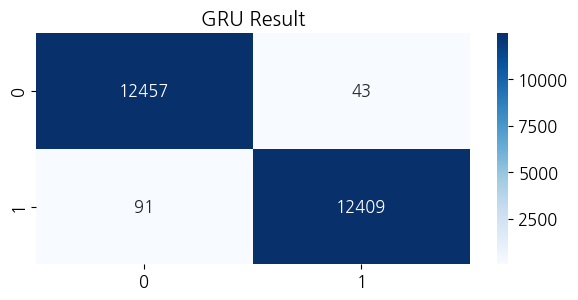

In [23]:
cm = confusion_matrix(kdf['train'], kdf['pred'])

plt.figure(figsize=(7,3))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('GRU Result')
plt.show()
plt.close()